# Machine Vision - Practical 10 - Applied Deep Learning

You are going to tackle the problem of Image Classification on a challenging real-world task. In particular, we will try to recognize species in photos captured from camera traps i.e. static cameras set up in the wild using Deep Learning. The dataset used here is a subset from the Caltech Camera Traps collection (Beery et al., 2018).

On top of this notebook, there are some functions that need customization:
 Certain functions we will need are not yet implemented: 
 - [Data Loading Utilities](dataset.py)
 - [Other Useful Utilities](training_utils.py)
 
You are tasked with the completion of the missing code but are not restricted by the requirements defined. This is a real-world computer vision problem so you can **be creative** especially after you are done with the main TODO tasks!

# Task 0: Downloading Data and Installing Libraries

### TODO 0A: Download Camera Trap data 
Download the file *cct20_crops.zip* from Moodle and unzip its contents in the working directory where this Notebook exists.
These components should be:
* **train/**,**validation/** and **test/** directories that correpond to the training, validation and test images respectively
* **cct20_labels.json**: Meta file that points to sets of image paths and labels for each of train, validation and test splits. The splits here correspond to the splits provided by the providers of the dataset. This split corresponds to a realistic scenario where testing data contain some images that come from locations that are unseen in the training set.
* **cct20_labels_large.json**: Similar to above but with double number of images used in the training set
* **cct20_labels_random.json** Similar to cct20_labels.json but train, validation, test splits are defined randomly.
<br><br>

### TODO 0B:  Install Additional Libraries 
In addition to libraries installed in previous labs **PyTorch, Torchvision and PIL** should be installed for this task. 

#### Installing PyTorch / Torchvision

The PyTorch version usually depends on the computation capabilities of the machine. However, we tried to keep the requirements minimal (installing the CPU version) so that the lab runs smoothly for everyone.<br>

You can install this library in your existing anaconda environment used for the Machine Vision course by running the following: <br> <br>
```conda install pytorch torchvision cpuonly -c pytorch``` 

Alternatively, if the above command does not work for you seek instructions [here](https://pytorch.org/get-started/locally/):   <br>

#### Installing PIL
```conda install -c anaconda pillow``` 
<br><br>

### TODO 0C  Exploit the rich documentation of PyTorch 
You may find practical help for the tools used on this lab under the [PyTorch](https://pytorch.org/docs/stable/index.html) or [Torchvision](https://pytorch.org/vision/stable/) documentations.
<br><br>

---

Loading Libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy

from PIL import Image
import torchvision
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.models as models

matplotlib.use('TkAgg')
%matplotlib inline

## NOTE: Reload the following libraries when functions and utilities are implemented
from dataset import CTDataset ##needs to be implemented (see below)
from training_utils import train,validate, accuracy #train, validate need to be implemented (see below)

---

# Task 1: Loading and Preparing Data

In [2]:
device='cpu'
## NOTE: 
## If you have a machine with a gpu and have installed the respective PyTorch version you an uncomment
## the following codeblock for faster experimentation

# if torch.cuda.is_available():
#     device = 'cuda'
# else:
#     device = 'cpu'

### Load annotation and path file
We load a python dictionary that for each of the train, validation and test splits has a list of rows that correspond to the path of the image, the target id and the class name correspond to this target id. <br>
Our training set consists of 12606 images that are distributed (in an imbalanced manner) across 15 species. Some of them are well represented and some not, some appear during day and some during night. In addition the data come from diverse locations and for some of them there is no overlap between the defined training and test sets.<br>

In [3]:
# Dictionary with train,val and test data and every row in format [img_path, class id, class name]
with open('cct20_labels.json') as f:
    cct20_dict = json.load(f) 

In [4]:
## list all species in training set
all_classes = list(set([row[2] for row in cct20_dict['train']]))
num_classes = len(all_classes) 
print('Total of {} classes in the training set. \nThese are:{}'.format(num_classes,', '.join(all_classes)))

Total of 15 classes in the training set. 
These are:deer, dog, bobcat, coyote, badger, raccoon, rabbit, fox, cat, rodent, bird, skunk, car, opossum, squirrel


#### Parameters
Some parameters for the upcoming tasks. You can play with these later and observe how performance is affected (if computation capabilities allow).

In [5]:
initial_img_res=32 #initial image resolution (resize and crop might have a different resolution, i.e. if we want the crop to be a subset of the original image for extra variation
#final_img_res = 50
final_img_res = 32 #final image resolution
batch_size = 32 #batch_size
num_epochs = 10 #number of training epochs

### TODO 1A: Pick a set of augmentations for training and validation set of the given task
During deep learning training, image augmentations can be used to provide a variety in the visual appearance of the input data given that the learning stage comprises of multiple epochs/steps.
There is not a unique correct answer here but try to choose a reasonable set of augmentations should for the task at hand.<br><br>
**Please fill the following cell**

In [6]:
## TODO: Comment out the following transformation placeholders and implement a reasonable set of transformations for the task at hand
train_transform = T.Compose([])
val_test_transform = T.Compose([])

train_transform = T.Compose([
    T.Resize(size=(initial_img_res,initial_img_res)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

val_test_transform = T.Compose([
    T.Resize(size=(initial_img_res,initial_img_res)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
## Other Reasonable Transformations to include in the final set of composed augmentations:

## Color Jittering
# T.RandomApply([T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)]) 

## Normalization with ImageNet image statistics. NOTE: needs to take place with image in Tensor format
# T.Normalize(mean = [ 0.485, 0.456, 0.406 ],std = [ 0.229, 0.224, 0.225 ]) 

### TODO 1B: Edit the camera trap dataset class [CTDataset](dataset.py )
The Dataset class defines how our training, validation and test datasets are initialized and what is returned when we load data every iteration. Currently CTDataset is a placeholder class under dataset.py. 
We want CTDataset class to receive as **input** the annotation file loaded above but for the particular split (train,validation,test) and the transformation implemented in the above task and **return** for each item in the batch a dictionary with the following key entries: *'img_path', 'target' and 'species'* (information from cct20_labels.json). To get inspiration about custom dataset class construction take a look at [this link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).<br><br>

**Fill CTDataset dataset.py for this task**.

For each split we define the dataset classes based on CTDataset class and the respective set of annotations and transformations

In [7]:
train_set = CTDataset(annotation_dict=cct20_dict['train'],transform=train_transform)
val_set = CTDataset(annotation_dict=cct20_dict['validation'],transform=val_test_transform)
test_set = CTDataset(annotation_dict=cct20_dict['test'],transform=val_test_transform)

Definition of data loaders for the predefined sets.
To learn more about how data loaders work follow this [link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) from the PyTorch documentation.

In [8]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

### Show how transformed images look like
We preview what kind of transformations come out of the constructed Dataloaders. Below, we see differently augmented versions (some augmentations are stochastic) for each of the images subsampled from the constructed training set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

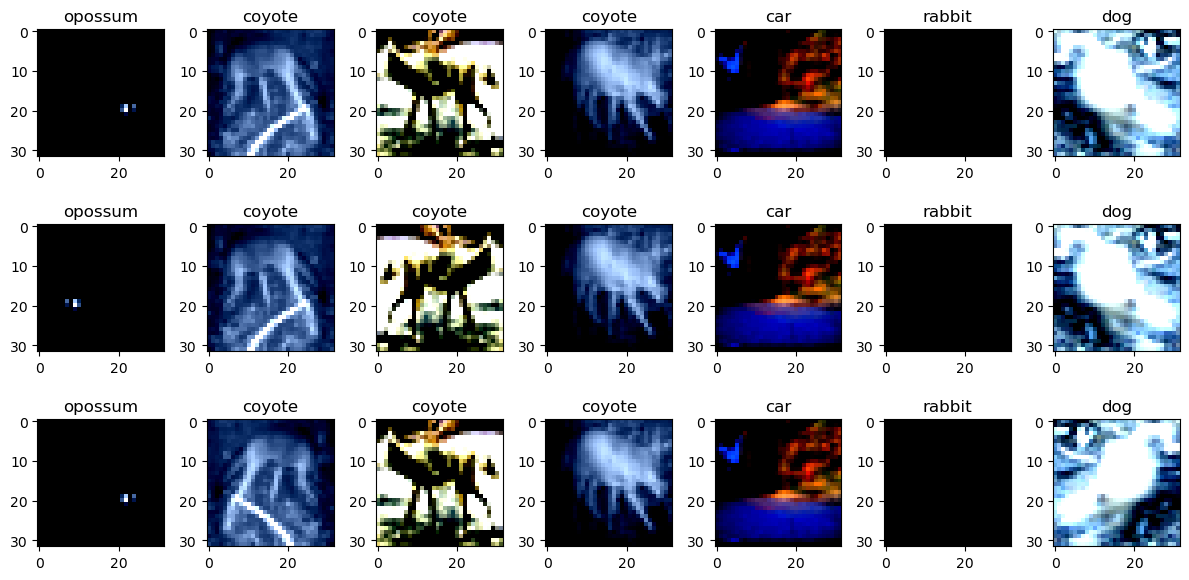

In [9]:
total_images = 7
total_iter = 3

np.random.seed(42)
random_image_idx =np.random.choice(list(range(0, len(train_set))),total_images)
train_set_subset = torch.utils.data.Subset(train_set, random_image_idx)

random_images = np.random.choice(range(0,batch_size),total_images)
fig,ax = plt.subplots(total_iter,total_images,figsize=(12,6))
for i in range(total_iter):
    train_loader_example = DataLoader(train_set_subset, batch_size=total_images, shuffle=False,drop_last=False)
    loaded_sample = next(iter(train_loader_example))
    for j in range(total_images):
        ax[i,j].imshow(np.array(loaded_sample['img'][j].permute([1,2,0]).cpu()))
        ax[i,j].set_title(loaded_sample['species'][j])
plt.tight_layout()

# Task 2 - Training and Evaluation

### TODO 2A: Implement the [train](training_utils.py) and [validate](training_utils.py) utility functions
The dataloaders defined above load the data for each batch either during the training or the inference stage. The train and validate functions correspond to the actions taken during a step/epoch of the training or validation phase respectively. The main difference is that during the training phase optimization takes place and the gradients are updated based on the defined loss function.

#### Training a model from Scratch
We are going to use one of the convolutional neural network architectures already implemented in torchvision and train it from scratch on species recognition on Caltech Camera Traps (CCT20). If you wanna learn more about the network architectures follow the torchvision documentation or read the respective paper that suggested it.

In [10]:
## set a constant instead of random seed for repeatability
torch.manual_seed(42)

In [11]:
## Loading a model implemented in PyTorch 
## ResNet18 is picked arbitrarily here, we can select other architectures supported.
model = models.resnet18()
## Input Features before final layer of the model
num_ftrs = model.fc.in_features
## Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).Output size equals the number of classes.  There are 15 classes in CCT20
model.fc = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
## Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
train_set.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


Training model from scratch... As the final model we keep the one that achieved the highest validation accuracy during training. <br>
**TODO: Uncomment the loop that runs train(), validate() etc. when you have implemented them**

In [13]:
best_val_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_acc_list = []
val_acc_list = []
## TODO: Uncomment the following lines when ready
# main train loop
for epoch in range(0, num_epochs):
    print("Train epoch {} ... \n".format(epoch))
    train_loss,train_acc = train(train_loader, model, criterion,optimizer, device)  
    val_loss, val_acc,_ = validate(val_loader,model,criterion,device,split='val')
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    if val_acc>best_val_acc:
        print('New best validation accuracy on epoch {} \n \n'.format(epoch))
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        
print(f'Best validation Accuracy: {best_val_acc:4f} achieved on epoch {best_epoch}')

Train epoch 0 ... 

Train. Prec@1 0.402
Train. Loss 1.855

Val prec@1 0.285
Val loss 2.249

New best validation accuracy on epoch 0 
 

Train epoch 1 ... 

Train. Prec@1 0.494
Train. Loss 1.514

Val prec@1 0.360
Val loss 2.101

New best validation accuracy on epoch 1 
 

Train epoch 2 ... 

Train. Prec@1 0.542
Train. Loss 1.351

Val prec@1 0.448
Val loss 1.930

New best validation accuracy on epoch 2 
 

Train epoch 3 ... 

Train. Prec@1 0.590
Train. Loss 1.215

Val prec@1 0.456
Val loss 1.949

New best validation accuracy on epoch 3 
 

Train epoch 4 ... 

Train. Prec@1 0.629
Train. Loss 1.099

Val prec@1 0.467
Val loss 1.859

New best validation accuracy on epoch 4 
 

Train epoch 5 ... 

Train. Prec@1 0.642
Train. Loss 1.056

Val prec@1 0.460
Val loss 1.804

Train epoch 6 ... 

Train. Prec@1 0.672
Train. Loss 0.974

Val prec@1 0.489
Val loss 1.731

New best validation accuracy on epoch 6 
 

Train epoch 7 ... 

Train. Prec@1 0.707
Train. Loss 0.878

Val prec@1 0.503
Val loss 1.699



#### Training Accuracy vs Validation Accuracy across the epochs of training (Plot)
We plot the progress of the training and the validation accuracy given predictions by the model during its training stages. Are we overfitting? 

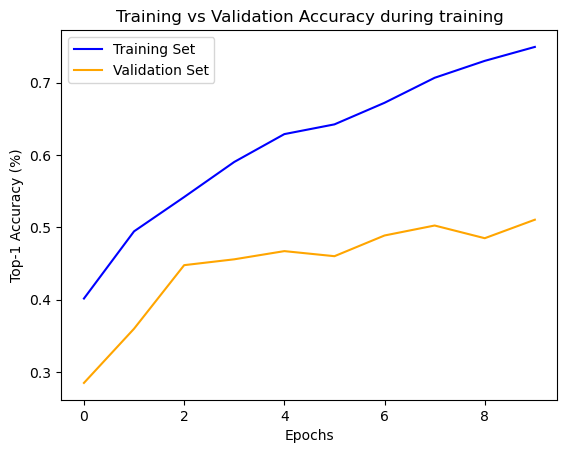

In [14]:
plt.title('Training vs Validation Accuracy during training')
plt.plot(train_acc_list,color='blue',  label = 'Training Set')
plt.plot(val_acc_list,color='orange',  label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Top-1 Accuracy (%)')
plt.legend()
plt.show()

#### Apply best model on the unseen test set

In [15]:
# load best model weights
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [16]:
## Evaluate on unseen test set
_, test_acc,preds = validate(test_loader,model,criterion,device,split='test')

Test prec@1 0.527
Test loss 1.659



#### Accuracy per Species (Plot)
In situations with class imbalance it's **important** to evaluate accuracy across labels or calculate metrics that are robust against imbalance. This evaluation takes place on predictions coming from the test set.

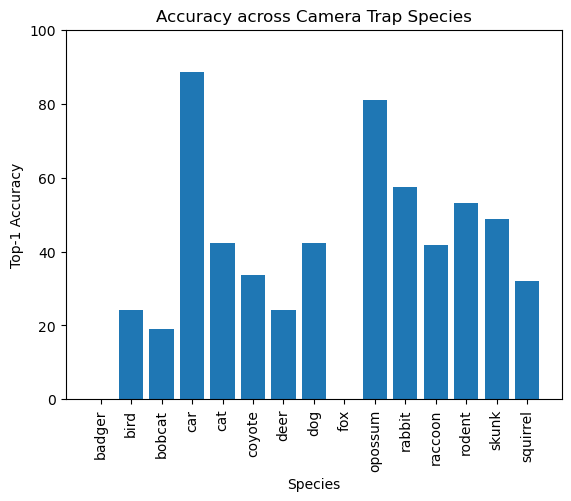

In [17]:
## given returned list of predictions and ground truth we calculate and plot accuracy per target
correct_per_target = (np.array(test_set.targets) == np.array(preds))
correct_per_species = {}
if len(correct_per_target)>0: # to not break when we run the functions with placeholders (before tasks are done)
    for i,species in enumerate(test_set.species):
        if species not in correct_per_species:
            correct_per_species[species] = []
        correct_per_species[species].append(correct_per_target[i])
    species_ordered = sorted(correct_per_species.keys())
    acc_per_species = []
    for species in species_ordered:
        acc_per_species.append(np.mean(correct_per_species[species])*100)

    plt.title('Accuracy across Camera Trap Species')
    plt.bar(species_ordered,acc_per_species)
    plt.xlabel('Species')
    plt.xticks(rotation = 90)
    plt.ylabel('Top-1 Accuracy')
    plt.ylim(0,100)
    plt.show()
    ## NOTE: badger and deer are very underrepresented

#### Transfer Learning
Now let's use the same architecture used above (i.e. ResNet18) but instead start from a pretrained version (ImageNet weights) instead of training from scratch.Transfer-learning from models pretrained on larger datasets is quite common practice in computer vision, i.e. models can be pretrained on ImageNet which instead totals around 1 million images that cover 1000 different classes.

In [18]:
## Loading a model implemented in PyTorch PRETRAINED on ImageNet 
## ResNet18 is picked arbitrarily here, we can select other architectures supported.
model = models.resnet18(pretrained=True)
## Input Features before final layer of the model
num_ftrs = model.fc.in_features
## Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).Output size equals the number of classes.  There are 15 classes in CCT20.
model.fc = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
## Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\33173/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.0MB/s]


Finetuning model on top of weights learnt from ImageNet. As the final model we keep the one that achieved the highest validation accuracy during training.<br>
**TODO: Uncomment the loop that runs train(), validate() etc. when you have implemented them**

In [20]:
best_val_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_acc_list = []
val_acc_list = []

## TODO: Uncomment the following lines when ready
# main train loop
for epoch in range(0, num_epochs):  
    print("Train epoch {} ... \n".format(epoch))
  
    train_loss,train_acc = train(train_loader, model, criterion,optimizer,device)  
    val_loss, val_acc,_ = validate(val_loader,model,criterion,device,split='val')
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    if val_acc>best_val_acc:
        print('New best validation accuracy on epoch {} \n \n'.format(epoch))
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        
print(f'Best validation Accuracy: {best_val_acc:4f} achieved on epoch {best_epoch}')

Train epoch 0 ... 

Train. Prec@1 0.495
Train. Loss 1.577

Val prec@1 0.459
Val loss 1.776

New best validation accuracy on epoch 0 
 

Train epoch 1 ... 

Train. Prec@1 0.659
Train. Loss 1.057

Val prec@1 0.530
Val loss 1.449

New best validation accuracy on epoch 1 
 

Train epoch 2 ... 

Train. Prec@1 0.738
Train. Loss 0.805

Val prec@1 0.589
Val loss 1.326

New best validation accuracy on epoch 2 
 

Train epoch 3 ... 

Train. Prec@1 0.785
Train. Loss 0.659

Val prec@1 0.590
Val loss 1.345

New best validation accuracy on epoch 3 
 

Train epoch 4 ... 

Train. Prec@1 0.816
Train. Loss 0.555

Val prec@1 0.626
Val loss 1.356

New best validation accuracy on epoch 4 
 

Train epoch 5 ... 

Train. Prec@1 0.839
Train. Loss 0.495

Val prec@1 0.622
Val loss 1.296

Train epoch 6 ... 

Train. Prec@1 0.862
Train. Loss 0.419

Val prec@1 0.638
Val loss 1.427

New best validation accuracy on epoch 6 
 

Train epoch 7 ... 

Train. Prec@1 0.889
Train. Loss 0.346

Val prec@1 0.649
Val loss 1.271



#### Training Accuracy vs Validation Accuracy across the epochs of training (Plot)
We plot the progress of the training and the validation accuracy given predictions by the model during its training stages. Are we overfitting? 

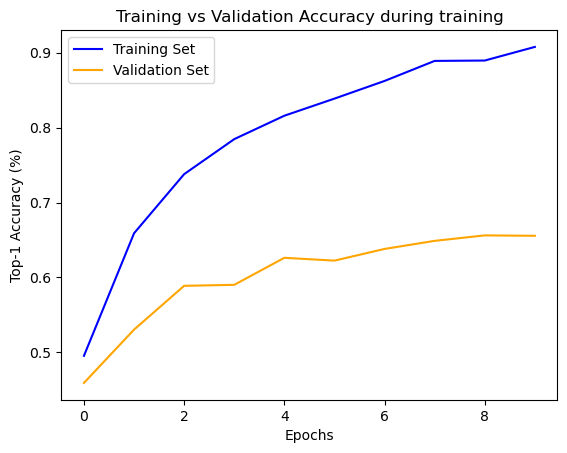

In [21]:
plt.title('Training vs Validation Accuracy during training')
plt.plot(train_acc_list,color='blue',  label = 'Training Set')
plt.plot(val_acc_list,color='orange',  label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Top-1 Accuracy (%)')
plt.legend()
plt.show()

#### Apply best model on the unseen test set

In [22]:
# load best model weights
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [23]:
## Evaluate on unseen test set
_, test_acc,preds = validate(test_loader,model,criterion,device,split='test')

Test prec@1 0.652
Test loss 1.403



#### Accuracy per Speciesc (Plot)
In situations with class imbalance it's **important** to evaluate accuracy across labels or calculate metrics that are robust against imbalance. This evaluation takes place on predictions coming from the test set.

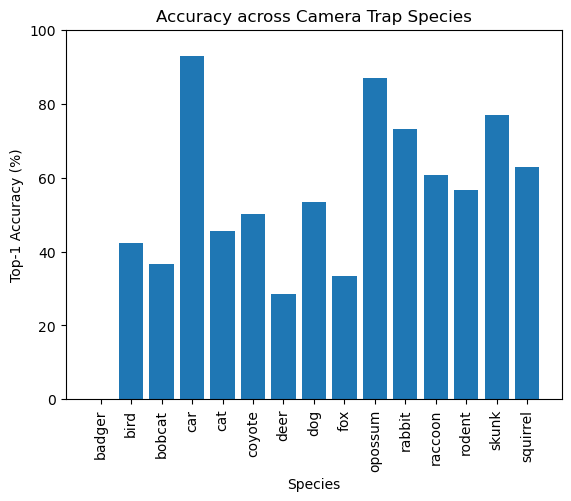

In [24]:
## given returned list of predictions and ground truth we calculate and plot accuracy per target
correct_per_target = (np.array(test_set.targets) == np.array(preds))
correct_per_species = {}
if len(correct_per_target)>0: # to not break when we run the functions with placeholders (before tasks are done)
    for i,species in enumerate(test_set.species):
        if species not in correct_per_species:
            correct_per_species[species] = []
        correct_per_species[species].append(correct_per_target[i])
    species_ordered = sorted(correct_per_species.keys())
    acc_per_species = []
    for species in species_ordered:
        acc_per_species.append(np.mean(correct_per_species[species])*100)

    plt.title('Accuracy across Camera Trap Species')
    plt.bar(species_ordered,acc_per_species)
    plt.xlabel('Species')
    plt.xticks(rotation = 90)
    plt.ylabel('Top-1 Accuracy (%)')
    plt.ylim(0,100)
    plt.show()
    ## NOTE: badger and deer are very underrepresented

### Task 2B: Larger training size

Now let's use a larger portion of data in our training set.
* Replace *cct20_labels.json* with *cct20_labels_large.json*
* Re-run the above chunk of code. You can run either training from random initialization OR transfer learning for simplicity
* What are your findings on the results after increasing the training data?


### Task 2C: Alternative splits where data are split differently

Similarly to above, we replace dataset with an alternative version. Here we use the same images as in *cct20_labels.json* but the train/validation/test splits are selected randomly. 
* Replace *cct20_labels.json* with *cct20_labels_random.json*
* Re-run the above chunk of code. You can run either training from random initialization OR transfer learning for simplicity
* What are your findings on the results after training with random? What's the relationship between the training and the validation/test loss now?

## Additional Tasks (Optional)
* You can **run for more epochs** to actually reach a point where the model converges. It just takes a lot of time for this lab session
* Experiment **by changing the utilized loss function or the gradient optimizer and** its parameters. 
* Select **different augmentations or the training images to be loaded**. 
* Select final model based on a different criterion. I.e. model that came out from last training step instead of one corresponding to the validation accuracy.
* **Increase image size** from 32 by 32. Actually that is quite small. Classes with fine-grained differences might suffer from low resolution. A resolution around 128 would make more sense but hard to process without a GPU.
* **Use larger model**. Likewise, it's fair to assume that using a better backbone, e.g. by replacing the pre-implemented ResNet18 with a ResNet50 which has double the size of parameters will lead to better performance. Again, to use a larger backbone model you'll probably need a large machine